In [8]:
#conda install opencv

In [2]:
%matplotlib inline

#import cv2
import IPython
import math
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType, concat, udf, from_json, decode, length
# from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType, DoubleType, BinaryType, BooleanType
import os

In [3]:
pravega_jars = [
    'pravega-connectors-spark-0.4.0-SNAPSHOT.jar', 
    'pravega-keycloak-credentials-0.4.0-2030.d99411b-0.0.1-020.26736d2-shadow.jar']
spark_jars_conf = ','.join([os.path.join('/usr/local/share/java', j) for j in pravega_jars])
spark = (SparkSession
             .builder
             .appName('test1')
             .config('spark.jars', spark_jars_conf)
             .getOrCreate()
             )
spark.conf.set('spark.sql.shuffle.partitions', '1')
spark.conf.set('spark.sql.execution.arrow.enabled', 'true')

In [9]:
#controller = 'tcp://nautilus-pravega-controller.nautilus-pravega.svc.cluster.local:9090'
controller = 'tcp://127.0.0.1:9090'
scope = 'examples'
df0 = (spark
      .readStream
      .format("pravega")
      .option("controller", controller)
      .option("scope", scope)
      .option("stream", "combinedvideo")
      #.option("encoding", "chunked_v1")
      .load()
      )

In [10]:
df0.printSchema()

root
 |-- event: binary (nullable = true)
 |-- scope: string (nullable = true)
 |-- stream: string (nullable = true)
 |-- segment_id: long (nullable = true)
 |-- offset: long (nullable = true)



In [11]:
#schema='timestamp timestamp, frame_number int, camera int, ssrc int, data binary'
schema='data binary'
df = df0.withColumnRenamed('event', 'raw_event')
df = df.select('*', decode('raw_event', 'UTF-8').alias('event_string'))
df = df.select('*', from_json('event_string', schema=schema).alias('event'))
df = df.select('*', 'event.*')
df = df.select('*', length('data'))
# df = df.withWatermark('timestamp', '1 second')
#df.printSchema()

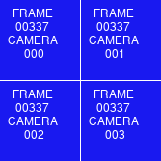

In [ ]:
def f(batch_df, batch_id):
    """Get first image at random and display it."""
#     print('batch_id=%d' % batch_id)
#     print('count=%d' % batch_df.count())
    images = batch_df.select('data').limit(1).collect()
    if images:
        png0 = images[0][0]
        IPython.display.clear_output(wait=True)
        IPython.display.display(IPython.display.Image(data=png0))
(df
 .writeStream
 #.trigger(processingTime='3 seconds')    # limit trigger rate
 .foreachBatch(f)
 .start()
 .awaitTermination()
)

In [ ]:
#spark.stop()